In [1]:
import geopandas
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn import metrics
from libpysal import weights
import divergence

%matplotlib inline

/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/libpysal/io/iohandlers/__init__.py:25: UserWarning: SQLAlchemy and Geomet not installed, database I/O disabled
  warnings.warn('SQLAlchemy and Geomet not installed, database I/O disabled')


# This may be a v. boring/dumb idea, but here goes

In [2]:
raw = geopandas.read_file('./betterblocks.geojson')
raw['total_pop'] = raw.total_pop.astype(int)
df = raw.query('total_pop > 0')

In [3]:
R = df.filter(regex='^pct')
race_columns = R.columns
R = R.values

Build up the same weights matrix we were using before, a second-order queen with attached islands (gets around disconnection issues in queen graph)

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter('once')
    Wqueen0 = weights.Queen.from_dataframe(raw, silence_warnings=True, 
                                   id_order=raw.index.tolist())
    Wqueen1 = weights.util.higher_order(Wqueen0)
    Wqueen2 = weights.util.higher_order(Wqueen0, k=3)
    #Wqueen_ho = lp.weights.Wsets.w_union(Wqueen1, Wqueen2)
    Wqueen_ho = Wqueen1
    Wqueen_all = weights.set_operations.w_union(Wqueen_ho, Wqueen0)
    Wqueen = weights.set_operations.w_subset(Wqueen_all,
                                       df.index.tolist())
    Wknn1 = weights.KNN.from_dataframe(df, k=1)
    W = weights.util.attach_islands(Wqueen, Wknn1)

/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/libpysal/weights/weights.py:169: UserWarning: There are 7 disconnected observations 
  Island ids: 2447, 2448, 2467, 3076, 3491, 4544, 6798
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))
/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/libpysal/weights/weights.py:169: UserWarning: There are 2 disconnected observations 
  Island ids: 9, 6804
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))
/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/libpysal/weights/weights.py:171: UserWarning: The weights matrix is not fully connected. There are 2116 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/libpysal/weights/weights.py:171: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matri

### Now, because of the eigenstructure, we need to just keep the big connected component for all of brooklyn and worry about the islands somehow else. 

In [5]:
Wc = weights.set_operations.w_subset(W, list(np.asarray(W.id_order)[W.component_labels==0]))

In [6]:
Rc = R[W.component_labels == 0]
Rcdiv = divergence.pairwise.jensen_shannon(Rc)

### So, let's say we're looking at the coffee shop I owe my dissertation to:

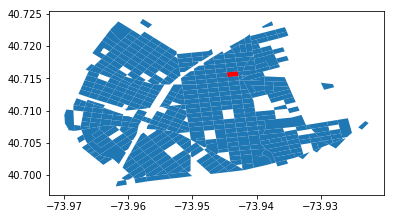

In [7]:
ax = df.query('zillowhood == "Williamsburg"').plot()
variety_wburg = df.query('geoid == "360470497002002"')
variety_wburg.plot(color='r', ax = ax)

In [8]:
dfc = df[W.component_labels == 0]

### When we look at the social distance matrix (the distances between racial compositions between blocks), we can see this distance varies non-uniformly over space:

(40.69818800020448, 40.72427099991492)

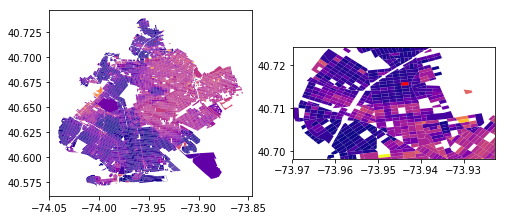

In [9]:
f,ax = plt.subplots(1,2,figsize=(8,4), 
                    subplot_kw=dict(aspect='equal'))
variety_wburg = df.query('geoid == "360470497002002"')
dfc.assign(demdist = Rcdiv[df.index.tolist().index(variety_wburg.index)])\
   .plot('demdist', cmap='plasma', ax=ax[0])
dfc.assign(demdist = Rcdiv[df.index.tolist().index(variety_wburg.index)])\
   .plot('demdist', cmap='plasma', ax=ax[1])
minx,miny,maxx,maxy=dfc.query('zillowhood=="Williamsburg"').total_bounds
[variety_wburg.plot(color='r', ax=ax_) for ax_ in ax]
ax[1].set_xlim(minx,maxx)
ax[1].set_ylim(miny,maxy)

Again, remember this is distance, so darker is closer in profile. 
It's cool that you can clearly see: this a gentrified area, we can see that it has strong affinity for the now gentrified area near the nostrand 2/5 to the east of Prospect Park (the big white space in the centre of brooklyn, even though this is *all the way* on the other side of bed stuy.

Also, we can see that it's got strong affinity forshit like coastal red hook, park slope, and borough park, all strong white areas, and brooklyn downtown. 

## Building up the re-embedding:

One concept could definitely be like... "the view from X", and you build up the point cloud placing the point at the center. There are algorithms to reconstruct arbitrary point clouds from distance matrices, but here I'm just gonna hack an sklearn solution

In [10]:
joint = Wc.sparse.multiply(Rcdiv)
joint.eliminate_zeros()
from scipy.sparse import csgraph

# The all-pairs shortest social path graph:

In [11]:
joint_div = csgraph.shortest_path(joint)

(40.69818800020448, 40.72427099991492)

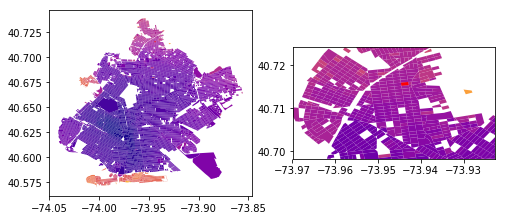

In [85]:
f,ax = plt.subplots(1,2,figsize=(8,4), 
                    subplot_kw=dict(aspect='equal'))
variety_wburg = df.query('geoid == "360470497002002"')
dfc.assign(demdist = joint_div[df.index.tolist().index(variety_wburg.index)])\
   .plot('demdist', cmap='plasma', ax=ax[0])
dfc.assign(demdist = joint_div[df.index.tolist().index(variety_wburg.index)])\
   .plot('demdist', cmap='plasma', ax=ax[1])
minx,miny,maxx,maxy=dfc.query('zillowhood=="Williamsburg"').total_bounds
[variety_wburg.plot(color='r', ax=ax_) for ax_ in ax]
ax[1].set_xlim(minx,maxx)
ax[1].set_ylim(miny,maxy)

In [84]:
# Give me a 2 dimensional manifold, sklearn!

In [77]:
embed = manifold.MDS(dissimilarity='precomputed').fit_transform(joint_div)

In [78]:
import seaborn

# Can we even see any patterns in the point cloud at large?

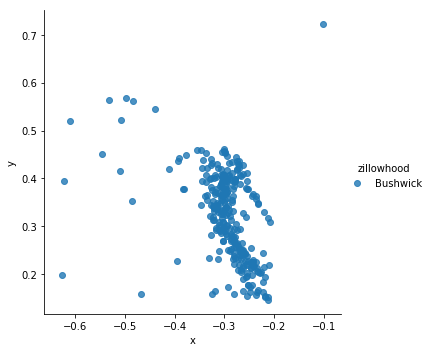

In [79]:
seaborn.lmplot('x','y',hue='zillowhood', fit_reg=False,
               data=dfc.assign(**dict(zip(('x','y'), embed.T))).query("zillowhood in @focus"))

In [80]:
from libpysal.cg import voronoi

In [81]:
vframe,_ = voronoi.voronoi_frames(embed)
vframe = vframe.assign(zillowhood = dfc.zillowhood.values)

# Can we see any structure by focusing back on my graham ave variety? 

In [88]:
vframe.intersects()

NameError: name 'vrame' is not defined

array([-0.77735845, -0.03589918,  0.13987129,  0.82977055])

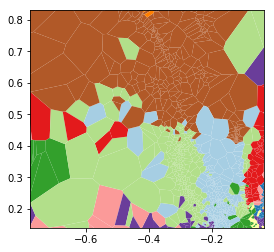

In [90]:
focus = 'Bushwick'
ax = vframe.plot('zillowhood', legend=False, cmap='Paired')
ax.axis(vframe.query('zillowhood == @focus').total_bounds[[0,2,1,3]])

In [97]:
vframe.to_file('latenthoods.geojson', driver='GeoJSON')

We could look again at the adjacency matrix in this space (Dropping the island/disconnected observations) and call this the "latent" neighborhood adjacency? Could be contrasted with the straightforwad NBFC set in attribute space. E.G. Wburg and red hook share a boundary here; they'd never ben considered spatially adjacent, but given their demographic similarity, they get connected 